# Plotting PyPSA results (adapted for Tutorial/default configuration of config.yaml file)

### Jupyter scripts need to be improved


In [ ]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

Cant find the repo path.


In [ ]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [11]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/Users/Lenovo/Desktop/pypsa-earth/results/networks/elec_s_55_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_55_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [12]:
n = n_solve

In [13]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones)

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,1.152425e+17,-161.895563,primary_energy,NaN,co2_emissions


In [14]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

n.objective / n.loads_t.p.sum().sum()

5725080018427.5625

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x28b2ccbab60>,
 <matplotlib.collections.LineCollection at 0x28b2dfce9e0>)

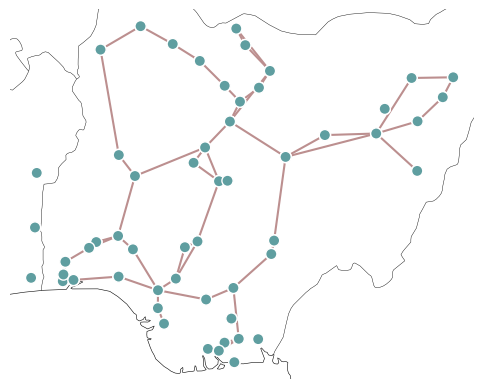

In [15]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

n.plot()

In [16]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps

len(n.snapshots)

624

### Overview components

In [17]:
#Imprimir la lista de componentes considerados en el dataframe creado (

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 165 entries
Component 'Carrier' has 18 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 60 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 220 entries
Component 'Load' has 55 entries
Component 'Generator' has 182 entries
Component 'StorageUnit' has 3 entries
Component 'Store' has 110 entries


### Energy balance

In [18]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
#https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BJ 0 H2          0.000000e+00
BJ 1 H2          0.000000e+00
BJ 2 H2          0.000000e+00
BJ 3 H2          0.000000e+00
NG 0 H2          0.000000e+00
                     ...     
NG 50 battery    0.000000e+00
NG 6 battery     9.313226e-10
NG 7 battery     0.000000e+00
NG 8 battery     2.793968e-09
NG 9 battery     9.313226e-10
Length: 110, dtype: float64

In [19]:
# se imprimen todos los generadores considerados en el modelo

n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators.head()

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'bus', 'carrier', 'p_nom_extendable',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BJ 0 CCGT,inf,0.000000,40.500000,99027.729293,0.58,40.500000,38.865178,BJ 0,CCGT,False,Slack,40.500000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BJ 0 oil,inf,0.000000,20.000000,37870.807407,0.35,20.000000,148.867027,BJ 0,oil,False,,20.000000,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BJ 0 onwind,2.203871e+04,838.372660,0.000000,96085.888020,1.00,0.000000,0.025793,BJ 0,onwind,True,,22022.337368,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BJ 0 solar,3.996201e+04,5958.612884,0.229229,35602.071244,1.00,0.229229,0.019591,BJ 0,solar,True,,39900.746113,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BJ 1 onwind,1.337156e+05,11482.097552,0.000000,96085.888020,1.00,0.000000,0.024869,BJ 1,onwind,True,Slack,133599.351760,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [20]:
#Imprimir solo los generadores de Bolivia

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [21]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Argentina

idx = ['AR' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

0.0

In [ ]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


1.564539882427637e+16

### Total installed generator capacity

In [24]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9140\2958603594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.472099e+03,2.970832e+05,1.74,1472.098949,116.595454,0,1.472099e+03,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
OCGT,NaN,0.000000,6.021930e+03,4.960499e+05,4.51,6021.930479,588.880783,11,2.512906e+13,11.000,0,0,0,11,0,0.0,11.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,11.0,11.0
load,NaN,0.000000,5.500000e+10,0.000000e+00,55.00,0.000000,55.550309,0,5.500000e+10,0.055,0,0,0,55,0,0.0,55.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,55.0,55.0
oil,NaN,0.000000,2.187625e+03,1.136124e+05,1.05,2187.625059,446.601448,0,2.187625e+03,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
onwind,1.679050e+06,140297.240417,1.112638e+00,5.284724e+06,55.00,1.112638,1.384243,55,1.677684e+06,55.000,0,0,0,55,0,0.0,55.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,55.0,55.0
solar,2.752780e+06,467701.923279,2.841582e+01,1.958114e+06,55.00,28.415818,1.100677,55,2.748522e+06,55.000,0,0,0,55,0,0.0,55.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,55.0,55.0


In [25]:
n.stores_t.p.head()

Store,BJ 0 H2,BJ 1 H2,BJ 2 H2,BJ 3 H2,NG 0 H2,NG 1 H2,NG 10 H2,NG 11 H2,NG 12 H2,NG 13 H2,NG 14 H2,NG 15 H2,NG 16 H2,NG 17 H2,NG 18 H2,NG 19 H2,NG 2 H2,NG 20 H2,NG 21 H2,NG 22 H2,NG 23 H2,NG 24 H2,NG 25 H2,NG 26 H2,NG 27 H2,NG 28 H2,NG 29 H2,NG 3 H2,NG 30 H2,NG 31 H2,NG 32 H2,NG 33 H2,NG 34 H2,NG 35 H2,NG 36 H2,NG 37 H2,NG 38 H2,NG 39 H2,NG 4 H2,NG 40 H2,NG 41 H2,NG 42 H2,NG 43 H2,NG 44 H2,NG 45 H2,NG 46 H2,NG 47 H2,NG 48 H2,NG 49 H2,NG 5 H2,NG 50 H2,NG 6 H2,NG 7 H2,NG 8 H2,NG 9 H2,BJ 0 battery,BJ 1 battery,BJ 2 battery,BJ 3 battery,NG 0 battery,NG 1 battery,NG 10 battery,NG 11 battery,NG 12 battery,NG 13 battery,NG 14 battery,NG 15 battery,NG 16 battery,NG 17 battery,NG 18 battery,NG 19 battery,NG 2 battery,NG 20 battery,NG 21 battery,NG 22 battery,NG 23 battery,NG 24 battery,NG 25 battery,NG 26 battery,NG 27 battery,NG 28 battery,NG 29 battery,NG 3 battery,NG 30 battery,NG 31 battery,NG 32 battery,NG 33 battery,NG 34 battery,NG 35 battery,NG 36 battery,NG 37 battery,NG 38 battery,NG 39 battery,NG 4 battery,NG 40 battery,NG 41 battery,NG 42 battery,NG 43 battery,NG 44 battery,NG 45 battery,NG 46 battery,NG 47 battery,NG 48 battery,NG 49 battery,NG 5 battery,NG 50 battery,NG 6 battery,NG 7 battery,NG 8 battery,NG 9 battery
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-4.494453e+06,-494.322510,345.633545,82.296875,525.794189,4.381890e+07,-1.444366e+09,-1.243230e+07,-2.156540e+09,-3.454545e+08,-5.854786e+06,-1.865858e+08,-3.994788e+09,-5.705061e+09,-2.563095e+07,3.723219e+05,1.793015e+06,-8.330766e+08,1.045718e+07,-3.198978e+08,-3.012714e+08,-5.467719e+08,-3.311989e+08,1.333618e+07,-7.463617e+08,-1.397130e+08,-1.172141e+09,-3.270482e+08,-2.099548e+07,-2.025408e+09,3.081153e+06,-2.363153e+07,-3.499709e+05,4.579452e+08,-3.182108e+08,-9.521216e+08,-275.102051,-8.927950e+08,1.379976e+07,-3.877508e+08,1.708120e+06,4.333525e+06,-2.220426e+09,-2.196653e+07,-8.639093e+07,-1.294493e+09,-1.249979e+07,2.952957e+07,-1.653572e+09,-2.685940e+09,-1.094329e+05,2.123974e+06,-2.231063e+08,-3.182376e+09,-1.302849e+09,4.823710e+03,6035.659065,-952.548616,5.934787,-984.732860,4.791785e+04,4.063760e+05,-8.940023e+04,-8.391318e+05,-1.108735e+06,-44045.843398,-2.659910e+05,-1.602758e+06,6.718890e+05,-3.256752e+04,2.638730e+05,-2.400877e+05,-6.094434e+05,3.877191e+05,-1.028976e+06,-1.097455e+06,-5.796176e+05,-1.112550e+06,-85907.761938,-9.586403e+05,-9.549449e+04,3.850384e+05,-1.106992e+06,9.405790e+05,1.589747e+05,7124.089387,3.931573e+05,1.260551e+05,-3.301852e+05,-1.111750e+06,-7.027574e+05,8648.410341,-8.831176e+05,3.462518e+05,-6.869547e+05,4.295449e+05,-1.890651e+05,2.509594e+05,-2.518990e+04,1.453559e+04,-8.909472e+05,-1.711217e+05,9.265157e+04,-1.113165e+06,1.678082e+05,1.001127e+05,4.465099e+05,1.668884e+05,-9.663603e+05,-2.981913e+06
2013-01-01 06:00:00,3.123861e+07,-664.406494,253.377930,27.367432,466.721191,-8.840850e+06,-1.243182e+09,1.164036e+07,-1.214159e+09,-2.198806e+08,-5.055857e+06,3.222889e+08,-3.832602e+09,-5.920554e+09,-4.531360e+06,-1.143001e+07,1.067360e+08,-7.379008e+08,6.517159e+06,3.522277e+08,-2.013191e+08,-4.916545e+08,-2.307978e+08,1.370251e+07,-4.925245e+08,-1.068814e+08,-1.188362e+09,-2.373376e+08,-2.391928e+07,-2.010614e+09,1.967838e+06,-2.425873e+07,2.271836e+07,1.209680e+10,-1.870435e+08,-8.230087e+08,-419.704590,9.765287e+09,6.803948e+06,-2.966021e+08,-1.574166e+07,-2.843761e+06,-2.249322e+09,-6.005515e+06,1.155308e+09,-1.142829e+09,1.433649e+07,-9.616066e+06,-1.243313e+09,-2.600028e+09,3.663505e+07,-1.698647e+07,-6.106195e+08,3.218551e+10,-1.244425e+09,7.135411e+05,-13711.306862,-2743.066112,-342.065173,-1715.395793,1.317476e+05,-8.195961e+05,8.095319e+05,1.924880e+06,1.889721e+06,34244.849088,1.827695e+06,2.847788e+06,-4.597241e+05,8.642514e+05,5.092898e+03,1.082352e+06,1.582403e+06,7.526342e+05,1.694236e+06,1.884831e+06,1.083517e+06,1.894211e+06,86569.649355,1.901365e+06,1.204619e+06,6.946872e+05,1.884803e+06,-4.632680e+05

<AxesSubplot:xlabel='snapshot'>

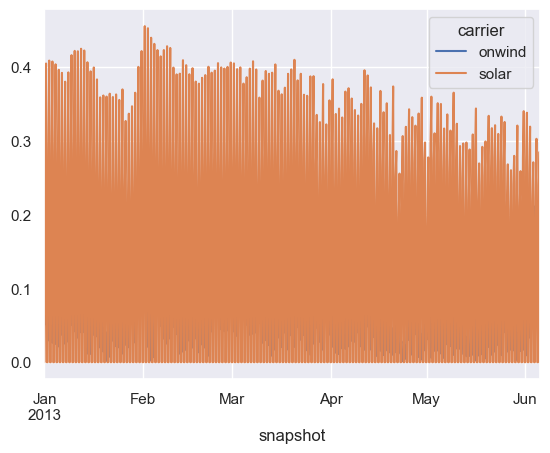

In [26]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [28]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [29]:
n.loads_t.p.sum().sum()

3572040.38411787

In [30]:
n.generators_t.p.sum().sum()

1.564539882784841e+16

In [31]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BJ 0  CCGT       1.215000e-05
      load       3.000000e+02
      oil        6.000000e-06
      onwind     0.000000e+00
      solar      6.876866e-08
                     ...     
NG 8  onwind     0.000000e+00
      solar      0.000000e+00
NG 9  load       3.000000e+02
      onwind     0.000000e+00
      solar      0.000000e+00
Name: p_nom, Length: 182, dtype: float64

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

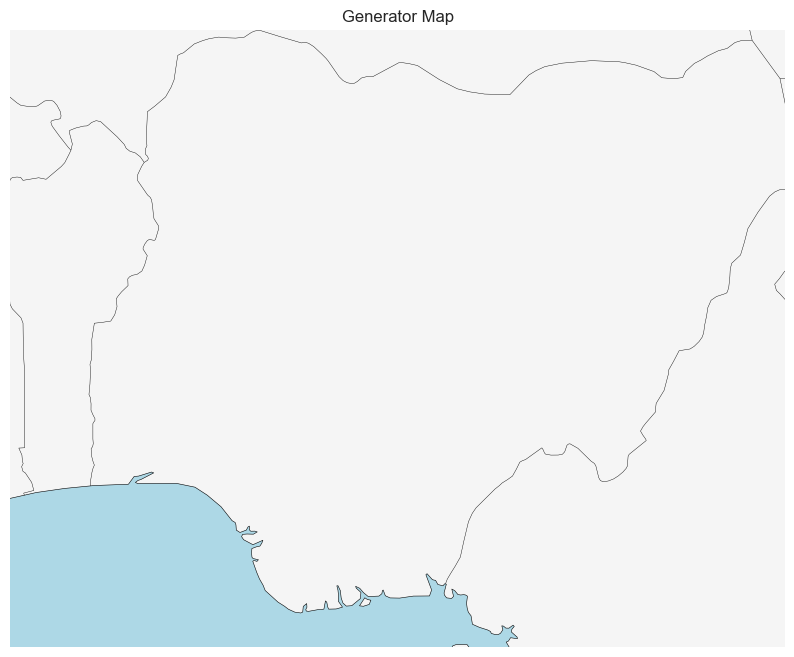

In [35]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [36]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BJ 0     1.000062e+09
BJ 1     1.000297e+09
BJ 2     1.000053e+09
BJ 3     1.000006e+09
NG 0     1.000016e+09
NG 1     1.000347e+09
NG 10    1.000328e+09
NG 11    1.000141e+09
NG 12    1.000235e+09
NG 13    1.000137e+09
NG 14    1.191027e+12
NG 15    1.000109e+09
NG 16    2.367381e+12
NG 17    2.130422e+12
NG 18    3.580816e+12
NG 19    1.000044e+09
NG 2     4.158840e+12
NG 20    1.000104e+09
NG 21    1.000068e+09
NG 22    1.000066e+09
NG 23    1.000101e+09
NG 24    1.000029e+09
NG 25    1.000262e+09
NG 26    1.292159e+12
NG 27    1.000094e+09
NG 28    1.000127e+09
NG 29    1.000011e+09
NG 3     1.000373e+09
NG 30    3.373465e+12
NG 31    1.000013e+09
NG 32    1.290937e+12
NG 33    1.000013e+09
NG 34    1.000076e+09
NG 35    1.000112e+09
NG 36    1.000081e+09
NG 37    1.000004e+09
NG 38    1.000150e+09
NG 39    1.000039e+09
NG 4     1.000072e+09
NG 40    1.000040e+09
NG 41    1.000040e+09
NG 42    1.000050e+09
NG 43    1.000101e+09
NG 44    1.000

<AxesSubplot:xlabel='snapshot'>

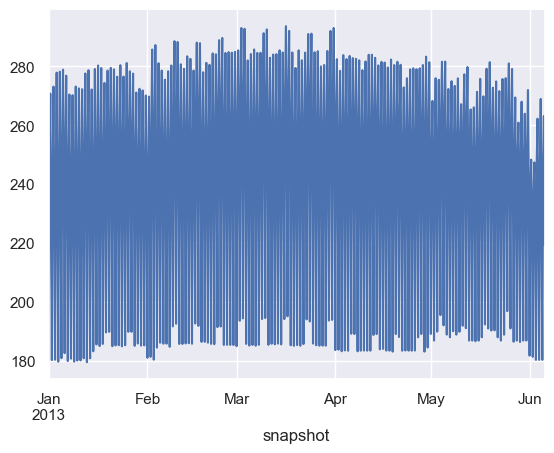

In [38]:
n.loads_t.p_set.loc["2013-01-01":"2013-06-06","NG 0"].plot()

In [39]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [40]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BJ 0     157739.884663
BJ 1      48389.427774
BJ 2      10194.508860
BJ 3      16941.582395
NG 0     150169.756875
NG 1     103559.352848
NG 10    209759.574563
NG 11     65038.216094
NG 12    109342.775946
NG 13     20432.566337
NG 14     47179.018241
NG 15     40173.319309
NG 16    175587.695235
NG 17     71466.869010
NG 18     53311.662574
NG 19     37858.281419
NG 2      25785.517980
NG 20    193557.983441
NG 21     36854.039049
NG 22     26115.245566
NG 23     34742.792294
NG 24     19348.186504
NG 25     48964.166030
NG 26     58710.968211
NG 27     33040.042007
NG 28     43581.383321
NG 29     58189.894999
NG 3      85991.541855
NG 30     49293.288084
NG 31     32403.840831
NG 32    149970.587655
NG 33    190921.500296
NG 34    161922.045446
NG 35     37132.125331
NG 36     15691.225132
NG 37     45445.274529
NG 38     33533.092741
NG 39     57837.192870
NG 4      30906.542648
NG 40     42622.810213
NG 41     44691.978272
NG 42     34778.994971
NG 43     49066.559479
NG 44  

In [41]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
BJ 0     157739.884663
BJ 1      48389.427774
BJ 2      10194.508860
BJ 3      16941.582395
NG 0     150169.756875
NG 1     103559.352848
NG 10    209759.574563
NG 11     65038.216094
NG 12    109342.775946
NG 13     20432.566337
NG 14     47179.018241
NG 15     40173.319309
NG 16    175587.695235
NG 17     71466.869010
NG 18     53311.662574
NG 19     37858.281419
NG 2      25785.517980
NG 20    193557.983441
NG 21     36854.039049
NG 22     26115.245566
NG 23     34742.792294
NG 24     19348.186504
NG 25     48964.166030
NG 26     58710.968211
NG 27     33040.042007
NG 28     43581.383321
NG 29     58189.894999
NG 3      85991.541855
NG 30     49293.288084
NG 31     32403.840831
NG 32    149970.587655
NG 33    190921.500296
NG 34    161922.045446
NG 35     37132.125331
NG 36     15691.225132
NG 37     45445.274529
NG 38     33533.092741
NG 39     57837.192870
NG 4      30906.542648
NG 40     42622.810213
NG 41     44691.978272
NG 42     34778.994971
NG 43     49066.559479
NG 44  

In [42]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BJ 0     1.000062e+09
BJ 1     1.000297e+09
BJ 2     1.000053e+09
BJ 3     1.000006e+09
NG 0     1.000016e+09
NG 1     1.000347e+09
NG 10    1.000328e+09
NG 11    1.000141e+09
NG 12    1.000235e+09
NG 13    1.000137e+09
NG 14    1.191027e+12
NG 15    1.000109e+09
NG 16    2.367381e+12
NG 17    2.130422e+12
NG 18    3.580816e+12
NG 19    1.000044e+09
NG 2     4.158840e+12
NG 20    1.000104e+09
NG 21    1.000068e+09
NG 22    1.000066e+09
NG 23    1.000101e+09
NG 24    1.000029e+09
NG 25    1.000262e+09
NG 26    1.292159e+12
NG 27    1.000094e+09
NG 28    1.000127e+09
NG 29    1.000011e+09
NG 3     1.000373e+09
NG 30    3.373465e+12
NG 31    1.000013e+09
NG 32    1.290937e+12
NG 33    1.000013e+09
NG 34    1.000076e+09
NG 35    1.000112e+09
NG 36    1.000081e+09
NG 37    1.000004e+09
NG 38    1.000150e+09
NG 39    1.000039e+09
NG 4     1.000072e+09
NG 40    1.000040e+09
NG 41    1.000040e+09
NG 42    1.000050e+09
NG 43    1.000101e+09
NG 44    1.000013e+09
NG 45    1.000024e+09
NG 46 

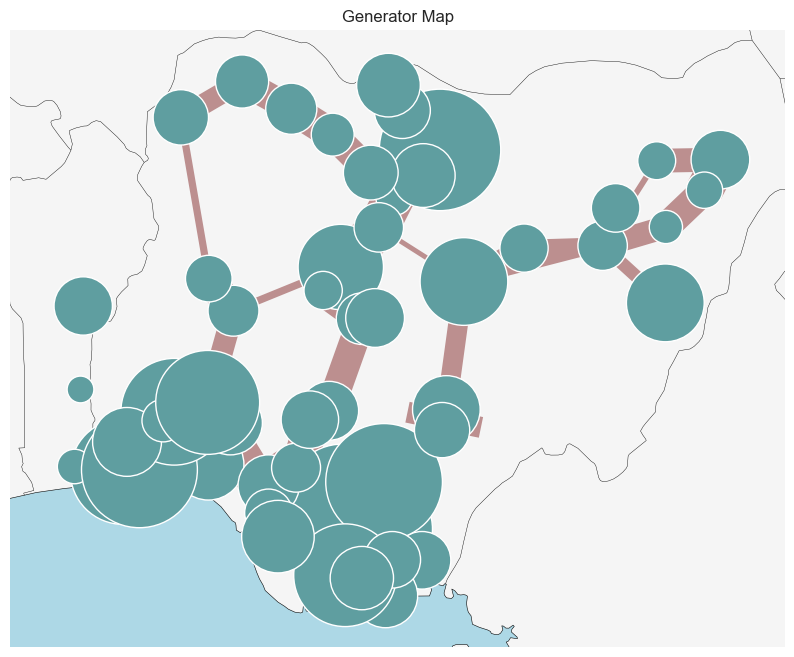

In [71]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [72]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus    carrier
BJ 0   CCGT       4.050000e+01
       load       1.000000e+09
       oil        2.000000e+01
       onwind     2.202234e+04
       solar      3.990075e+04
                      ...     
NG 50  AC load    2.574645e+04
NG 6   AC load    5.758808e+04
NG 7   AC load    1.535239e+05
NG 8   AC load    5.703757e+04
NG 9   AC load    4.694683e+04
Length: 237, dtype: float64

### Plot of Average Marginal Price

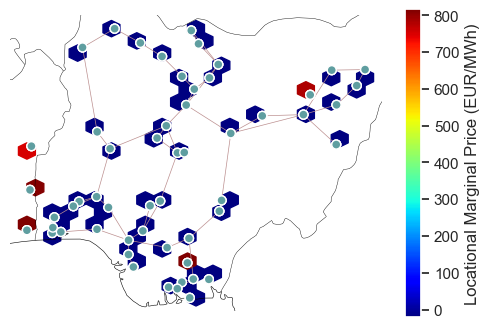

In [73]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

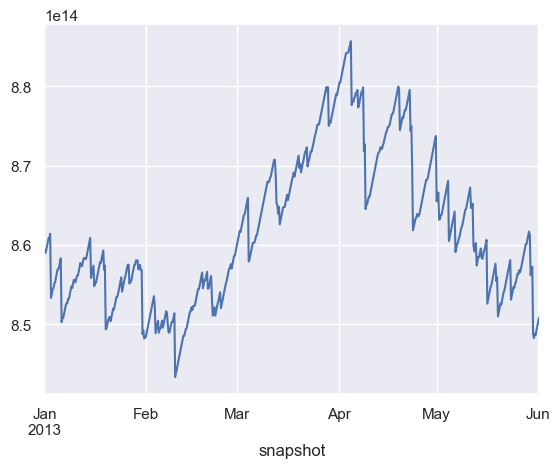

In [75]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [76]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       3.226248e+13
H2 fuel cell          2.189982e+13
battery charger       4.871994e+13
battery discharger    5.074994e+13
Name: p_nom_opt, dtype: float64